In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
import pickle
import time

In [2]:
# file 11 contains 28 Mar & 29 Mar
with open('df_0328_tweets.pickle', 'rb') as handle:
    df_0328_tweets = pickle.load(handle)

with open('df_0329_tweets.pickle', 'rb') as handle:
    df_0329_tweets = pickle.load(handle)
len(df_0328_tweets),len(df_0329_tweets)

(625523, 333494)

# Combine Data

In [137]:
# df_comb = pd.concat([df_0328_tweets,df_0329_tweets])
# df_comb.head()

created_at  \
0  Sat Mar 28 08:18:01 +0000 2020   
1  Sat Mar 28 08:18:01 +0000 2020   
2  Sat Mar 28 08:18:01 +0000 2020   
3  Sat Mar 28 08:18:01 +0000 2020   
4  Sat Mar 28 08:18:01 +0000 2020   

                                           full_text  \
0  RT @Being_Humor: When India was fighting Coron...   
1  RT @holasaraa: At this point if I see another ...   
2  RT @IndiaToday: #CoronavirusPandemic | IMF chi...   
3  RT @Kanagalogy: Where is India's Health Minist...   
4  Anger at Belgium’s dysfunctional political sys...   

                                        re_full_text  
0  When India was fighting Corona \n\n.@ndtv was ...  
1  At this point if I see another jogger claiming...  
2  #CoronavirusPandemic | IMF chief said global e...  
3  Where is India's Health Minister  @drharshvard...  
4

In [3]:
df_comb = df_0328_tweets

In [4]:
df_comb.shape

(625523, 3)

In [5]:
len(df_comb.full_text.unique()),len(df_comb.re_full_text.unique())

(239164, 46893)

In [6]:
full_texts = df_comb[df_comb['re_full_text']!='']['re_full_text'] # 转发的原文
len(full_texts),len(full_texts.unique()) #转发的原推数

(432607, 46892)

In [7]:
full_texts_orig = df_comb[df_comb['re_full_text']=='']['full_text'] #原创的且未在这个时间段被转发过
len(full_texts_orig),len(full_texts_orig.unique()) #大部分原创推特都没有重复

(192916, 191354)

In [183]:
full_texts_all = pd.concat([full_texts,full_texts_orig])
len(full_texts_all),len(full_texts_all.unique())

(625523, 210846)

# Multiprocessing

In [10]:
import multiprocessing as mp
import numpy as np
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

CPU numbers: 32


# Pos tagging

In [11]:
def getPos(s):
    return [i[1] for i in nltk.pos_tag(word_tokenize(s))]

In [14]:
# retweeted tweets
df = pd.DataFrame(pd.Series(full_texts).value_counts())
df = df.rename(columns={'re_full_text':'count'})
df['text'] = df.index
df.index = range(len(df))
s_py = time.time()
df['pos'] = apply_by_multiprocessing(df['text'], getPos, workers=32)
print("programme:",time.time()-s_py)
df.head()

programme: 10.458591222763062


count                                               text  \
0  29496  Due to Corona, we officially have three days o...   
1  18354  It’s time we all do our bit to help defeat #CO...   
2  17143  corona virus got people being horny, depressed...   
3   8874  That’s a brilliant fifty, @ImRaina! #IndiaFigh...   
4   7423  The lockdown situation adversely impacts the l...   

                                                 pos  
0  [JJ, TO, NNP, ,, PRP, RB, VBP, CD, NNS, IN, DT...  
1  [PRP, VBZ, JJ, NN, PRP, DT, VBP, PRP$, NN, TO,...  
2  [NN, NN, VBD, NNS, VBG, NN, ,, VBD, ,, JJ, CC,...  
3  [DT, VBZ, VBZ, DT, JJ, NN, ,, JJ, NNP, ., #, N...  
4  [DT, JJ, NN, RB, VBZ, DT, NNS, IN, JJ, NN, NN,...

In [168]:
# retweeted tweets
df = pd.DataFrame(pd.Series(full_texts).value_counts())
df = df.rename(columns={'re_full_text':'count'})
df['text'] = df.index
df.index = range(len(df))
# df['pos'] = [[i[1] for i in nltk.pos_tag(word_tokenize(s))] for s in tqdm(df['text'])]
df.head()

100%|██████████| 46892/46892 [01:18<00:00, 596.32it/s]


count                                               text  \
0  29496  Due to Corona, we officially have three days o...   
1  18354  It’s time we all do our bit to help defeat #CO...   
2  17143  corona virus got people being horny, depressed...   
3   8874  That’s a brilliant fifty, @ImRaina! #IndiaFigh...   
4   7423  The lockdown situation adversely impacts the l...   

                                                 pos  
0  [JJ, TO, NNP, ,, PRP, RB, VBP, CD, NNS, IN, DT...  
1  [PRP, VBZ, JJ, NN, PRP, DT, VBP, PRP$, NN, TO,...  
2  [NN, NN, VBD, NNS, VBG, NN, ,, VBD, ,, JJ, CC,...  
3  [DT, VBZ, VBZ, DT, JJ, NN, ,, JJ, NNP, ., #, N...  
4  [DT, JJ, NN, RB, VBZ, DT, NNS, IN, JJ, NN, NN,...

In [15]:
# original tweets
df_orig = pd.DataFrame(pd.Series(full_texts_orig).value_counts())
df_orig = df_orig.rename(columns={'full_text':'counts'})
df_orig['text'] = df_orig.index
df_orig.index = range(len(df_orig))
df_orig['pos'] = apply_by_multiprocessing(df_orig['text'], getPos, workers=32)
df_orig.head()

full_text                                               text  \
0        126  During this Corona crisis we thank the hero ph...   
1         18  @KSIOlajidebt Look at my wrist corona, my neck...   
2         17  @QueenSubb Pls ma am a hairdresser I can hardl...   
3         17  BCCI (@BCCI) richest cricket body in world, an...   
4         16                        Wake me up when corona ends   

                                                 pos  
0  [IN, DT, NNP, NN, PRP, VBD, DT, NN, NNS, IN, V...  
1  [JJ, NNP, NNP, IN, PRP$, NN, NN, ,, PRP$, NN, ...  
2  [JJ, NNP, NNP, NNP, VBP, DT, NN, PRP, MD, RB, ...  
3  [NNP, (, NNP, NNP, ), VBP, NN, NN, IN, NN, ,, ...  
4                        [VB, PRP, RP, WRB, NN, NNS]

In [234]:
df_total = pd.concat([df,df_orig])
df.shape,df_orig.shape,df_total.shape

((46892, 4), (191354, 3), (238246, 4))

In [28]:
with open('df_0328_retweeted.pickle','wb') as handle:
     pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('df_0328_orig.pickle','wb') as handle:
     pickle.dump(df_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [137]:
# Graph-based FP mining edges即为共现序列
def buildEdges(df, k=2, minS=10, raw=False, unique=False, pos=True):  
# l为输入的序列集合， k是序列中行为的个数 默认为2，minS是最小支持度 默认为10, 若raw为真返回原始全部dict数据
  edges = {}
  for r in range(len(df)):
    s = df.pos[r] if pos else word_tokenize(df.text[r])
    s=s[:]
    s.insert(0,'s') # start notation
    for i in range(len(s)):
      if i+ k <= len(s):
        edge = '-'.join(s[i:i+k]) 
        c = df.counts[r] if unique==False else 1
        if edge in edges:
          edges[edge] += c
        else:
          edges[edge] = c
  
  df_edges = pd.DataFrame(edges,index=['Support']).T.sort_values(by=['Support'],ascending=False)
  stat = {'TotalCombinations':len(df_edges),'min':df_edges['Support'].min(),
          'median':df_edges['Support'].median(),'mean':df_edges['Support'].mean(),
          'max':df_edges['Support'].max()
         }
  return df_edges[df_edges['Support']>minS],pd.DataFrame([stat]) if raw==False else edges
# 输出为tuple, [0]项为dataframe结果，[1]为全部组合的统计数据

In [31]:
buildEdges(df,2,10000, unique=True)[0]

Support
NNP-NNP    91835
JJ-NN      40031
NN-:       39761
DT-NN      37232
NN-IN      36203
NNP-NN     34194
:-NN       32688
NN-NN      30313
#-NNP      29493
IN-DT      27564
IN-NNP     21579
NN-.       21099
TO-VB      20031
PRP-VBP    18288
IN-NN      16843
NNP-#      16837
DT-JJ      16452
NN-NNP     14905
NNS-IN     12830
JJ-NNS     12246
MD-VB      11992
JJ-NNP     11663
NNP-.      11647
s-NNP      11020
NNP-IN     10657
DT-NNP     10363

In [138]:
buildEdges(df,3,10000, unique=True)[0]

Support
NNP-NNP-NNP    47963
NN-:-NN        29341
#-NNP-#        13572
NNP-#-NNP      13108
IN-DT-NN       13074
DT-NN-IN       10801
DT-JJ-NN       10318

In [139]:
buildEdges(df,4,5000, unique=True)[0]

Support
NNP-NNP-NNP-NNP    29549
#-NNP-#-NNP        10673
NNP-NN-:-NN         8580
NNP-#-NNP-#         7904
.-NN-:-NN           6597
JJ-NN-:-NN          5996

In [35]:
buildEdges(df,2,1000, unique=True, pos=False)[0]

Support
https-:           32230
s-@                6146
.-https            5043
corona-virus       4859
amp-;              4320
&-amp              4319
.-#                3492
’-s                3381
Corona-Virus       3298
!-!                3087
of-the             3020
Corona-virus       2900
in-the             2798
#-Corona           2795
’-t                2653
s-#                2505
the-corona         2220
s-I                2041
to-the             1907
the-Corona         1874
s-Corona           1826
#-COVID19          1631
s-The              1596
#-corona           1537
?-?                1469
for-the            1357
.-I                1345
is-a               1341
!-https            1313
.-@                1297
of-Corona          1291
virus-.            1282
I-’                1262
to-be              1252
#-coronavirus      1235
@-narendramodi     1142
is-the             1142
This-is            1140
of-corona          1129
s-This             1117
Corona-#           1115
.-The              1078
on-the             1061
:-https            1047
will-be            1039
’-m                1031
corona-#           1027
,-and              1026
the-world          1019

In [140]:
buildEdges(df,3,2000, unique=True, pos=False)[0]

Support
.-https-:     5043
&-amp-;       4319

# HashTags

In [142]:
all_hashtags = [] 
for text in tqdm(full_texts):
    tags = re.findall('#(.*?) ',text)
    all_hashtags.extend(tags)

100%|██████████| 432607/432607 [00:01<00:00, 320740.47it/s]


In [143]:
all_hashtags_orig = [] 
for text in tqdm(full_texts_orig):
    tags = re.findall('#(.*?) ',text)
    all_hashtags_orig.extend(tags)

100%|██████████| 192916/192916 [00:00<00:00, 296649.85it/s]


In [192]:
all_hashtags_total = pd.concat([pd.Series(all_hashtags),pd.Series(all_hashtags_orig)])
len(all_hashtags),len(all_hashtags_orig),len(all_hashtags_total)

(272482, 109192, 381674)

In [193]:
len(pd.Series(all_hashtags).unique()),len(pd.Series(all_hashtags_orig).unique()),len(pd.Series(all_hashtags_total).unique())

(13052, 27203, 31492)

In [146]:
pd.Series(all_hashtags).value_counts()

Corona               33540
IndiaFightsCorona    22059
COVID19.             19209
StayHomeIndia        19032
COVID19               7586
                     ...  
gondola                  1
clapforBoris             1
coronamedicine           1
care                     1
kirkroar                 1
Length: 13052, dtype: int64

In [147]:
pd.Series(all_hashtags_orig).value_counts()

Corona                5842
corona                5282
COVID19               3241
coronavirus           2719
CoronaUpdate          1875
                      ... 
findacure                1
nevada                   1
saabnation               1
weirdal                  1
littlecontribution       1
Length: 27203, dtype: int64

In [194]:
hashtags_dict = nltk.FreqDist(all_hashtags)
hashtags_orig_dict = nltk.FreqDist(all_hashtags_orig)
hashtags_total_dict = nltk.FreqDist(all_hashtags_total)

len(hashtags_dict),len(hashtags_orig_dict),len(hashtags_total_dict)

(13052, 27203, 31492)

# Word Frequency

In [149]:
#Traditional method takes 6 minutes
all_words = []
for text in tqdm(full_texts):
    tokens = word_tokenize(text)
    all_words.extend([i for i in tokens if i not in stopwordEn and i.isalpha()])

100%|██████████| 432607/432607 [06:02<00:00, 1191.88it/s]


In [167]:
#multiprocessing method takes 30 seconds
all_words = []
s_py = time.time()
for i in apply_by_multiprocessing(full_texts, processText, workers=32):
    all_words.extend(i)
print("programme:",time.time()-s_py)

programme: 30.015482902526855


In [162]:
all_words_orig = []
def processText(text):
    tokens = word_tokenize(text)
    return [i for i in tokens if i not in stopwordEn and i.isalpha()]
s_py = time.time()
for i in apply_by_multiprocessing(full_texts_orig, processText, workers=32):
    all_words_orig.extend(i)
print("programme:",time.time()-s_py)

programme: 12.39165735244751


In [188]:
all_words_total = pd.concat([pd.Series(all_words),pd.Series(all_words_orig)])
len(all_words),len(all_words_orig),len(all_words_total)

(7558601, 2744772, 10303373)

In [189]:
words_dict = nltk.FreqDist(all_words)
words_orig_dict = nltk.FreqDist(all_words_orig)
words_total_dict =  nltk.FreqDist(all_words_total)
len(words_dict),len(words_orig_dict),len(words_total_dict)

(75332, 168769, 182667)

# Word cloud

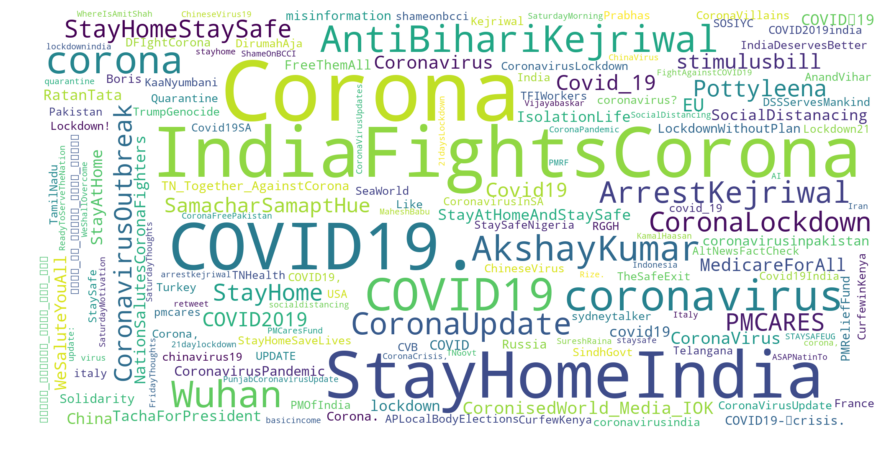

In [170]:
# tags cloud (retweeted tweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
# % matplotlib inline

wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=1000, background_color="white").generate_from_frequencies(hashtags_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [175]:
hashtags_dict.most_common(30)

[('Corona', 33540),
 ('IndiaFightsCorona', 22059),
 ('COVID19.', 19209),
 ('StayHomeIndia', 19032),
 ('COVID19', 7586),
 ('coronavirus', 6580),
 ('corona', 5444),
 ('Wuhan', 4924),
 ('AntiBihariKejriwal', 4912),
 ('AkshayKumar', 4320),
 ('CoronaUpdate', 3234),
 ('ArrestKejriwal', 3029),
 ('CoronaLockdown', 2444),
 ('CoronavirusOutbreak', 1965),
 ('PMCARES', 1903),
 ('StayHomeStaySafe', 1898),
 ('StayHome', 1777),
 ('Pottyleena', 1724),
 ('Covid_19', 1483),
 ('stimulusbill', 1417),
 ('SamacharSamaptHue', 1408),
 ('Covid19', 1287),
 ('COVID2019', 1277),
 ('EU', 1116),
 ('Coronavirus', 1083),
 ('MedicareForAll', 1013),
 ('CoronisedWorld_Media_IOK', 953),
 ('CoronaVirus', 923),
 ('WeSaluteYouAll', 884),
 ('StayAtHome', 852)]

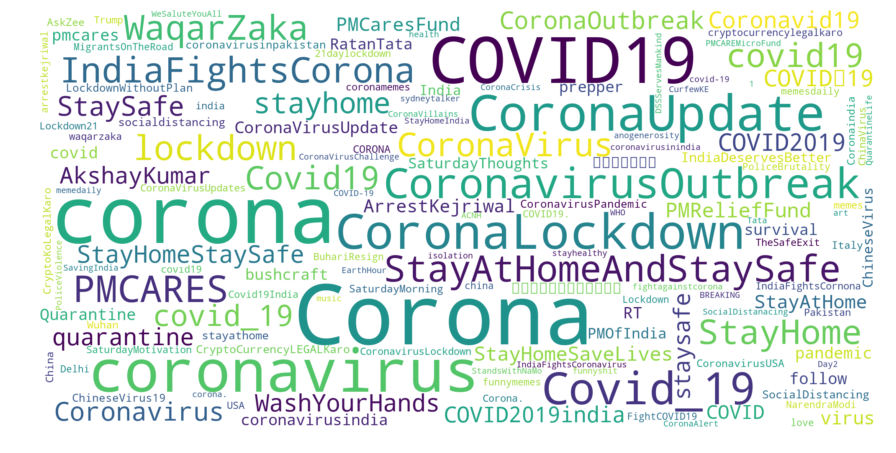

In [176]:
# tags cloud (original tweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=1000, background_color="white").generate_from_frequencies(hashtags_orig_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [190]:
hashtags_orig_dict.most_common(30)

[('Corona', 5842),
 ('corona', 5282),
 ('COVID19', 3241),
 ('coronavirus', 2719),
 ('CoronaUpdate', 1875),
 ('CoronaLockdown', 1785),
 ('Covid_19', 1503),
 ('CoronavirusOutbreak', 1300),
 ('PMCARES', 982),
 ('StayAtHomeAndStaySafe', 953),
 ('IndiaFightsCorona', 879),
 ('lockdown', 828),
 ('WaqarZaka', 822),
 ('StayHome', 809),
 ('CoronaVirus', 775),
 ('covid19', 773),
 ('Covid19', 734),
 ('covid_19', 602),
 ('stayhome', 583),
 ('StaySafe', 506),
 ('', 504),
 ('Coronavirus', 462),
 ('CoronaOutbreak', 422),
 ('WashYourHands', 407),
 ('StayHomeStaySafe', 407),
 ('COVID2019', 406),
 ('quarantine', 397),
 ('AkshayKumar', 388),
 ('Coronavid19', 386),
 ('COVIDー19', 385)]

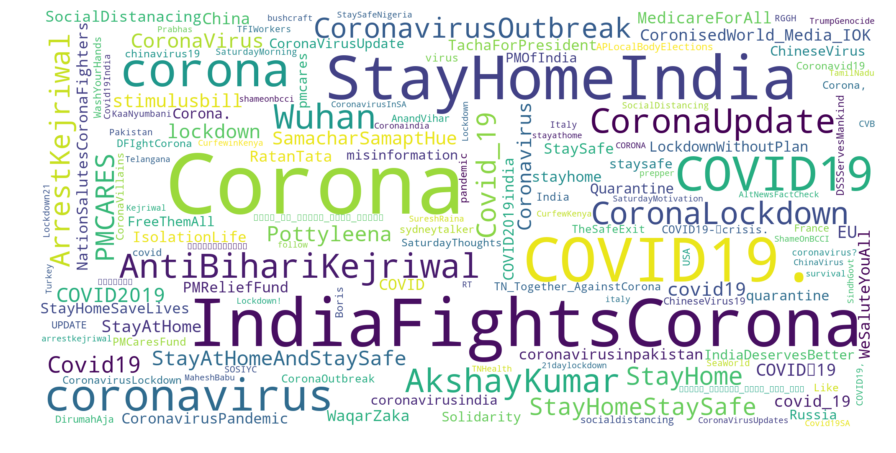

In [196]:
# tags cloud (with retweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=1000, background_color="white").generate_from_frequencies(hashtags_total_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [197]:
hashtags_total_dict.most_common(30)

[('Corona', 39382),
 ('IndiaFightsCorona', 22938),
 ('COVID19.', 19315),
 ('StayHomeIndia', 19109),
 ('COVID19', 10827),
 ('corona', 10726),
 ('coronavirus', 9299),
 ('CoronaUpdate', 5109),
 ('Wuhan', 5062),
 ('AntiBihariKejriwal', 4947),
 ('AkshayKumar', 4708),
 ('CoronaLockdown', 4229),
 ('ArrestKejriwal', 3301),
 ('CoronavirusOutbreak', 3265),
 ('Covid_19', 2986),
 ('PMCARES', 2885),
 ('StayHome', 2586),
 ('StayHomeStaySafe', 2305),
 ('Covid19', 2021),
 ('Pottyleena', 1774),
 ('StayAtHomeAndStaySafe', 1736),
 ('CoronaVirus', 1698),
 ('COVID2019', 1683),
 ('Coronavirus', 1545),
 ('lockdown', 1534),
 ('covid19', 1492),
 ('stimulusbill', 1421),
 ('SamacharSamaptHue', 1408),
 ('EU', 1170),
 ('COVIDー19', 1161)]

# Word Cloud

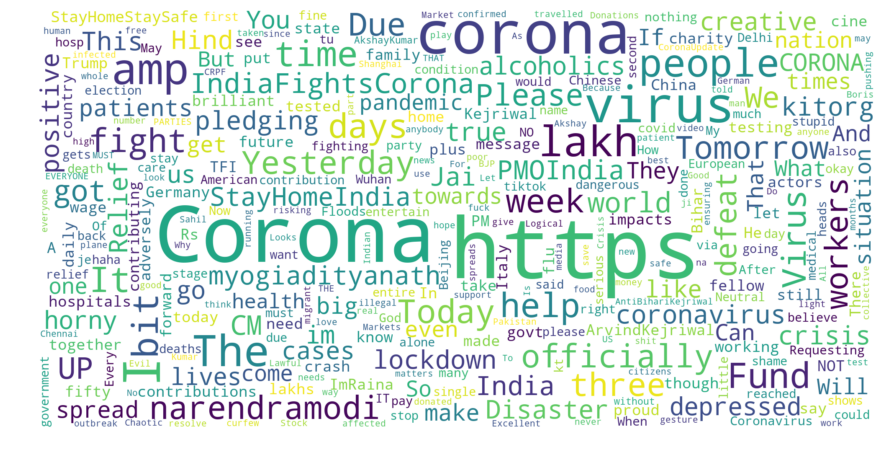

In [205]:
# vocabulary word cloud 1-gram
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate_from_frequencies(words_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [211]:
words_dict.most_common(30)

[('https', 258298),
 ('Corona', 224639),
 ('corona', 119636),
 ('I', 86714),
 ('virus', 83068),
 ('amp', 60765),
 ('The', 59432),
 ('lakh', 55992),
 ('people', 47728),
 ('bit', 40794),
 ('It', 39232),
 ('Fund', 38903),
 ('time', 38736),
 ('help', 34978),
 ('days', 34844),
 ('Virus', 33625),
 ('Today', 32433),
 ('fight', 32031),
 ('week', 31971),
 ('officially', 30085),
 ('Yesterday', 30074),
 ('three', 29934),
 ('Due', 29758),
 ('Tomorrow', 29589),
 ('narendramodi', 29368),
 ('workers', 28584),
 ('Please', 26462),
 ('UP', 25855),
 ('got', 24784),
 ('defeat', 24649)]

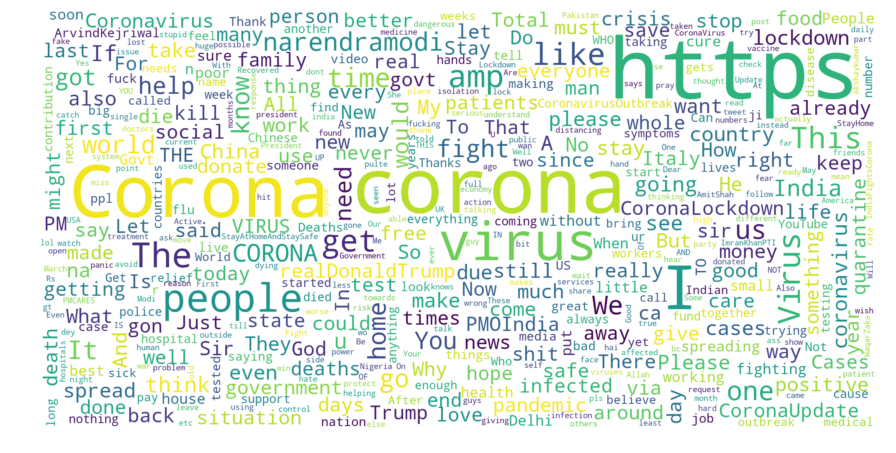

In [209]:
# vocabulary word cloud 1-gram
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate_from_frequencies(words_orig_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [212]:
words_orig_dict.most_common(30)

[('https', 99359),
 ('corona', 83311),
 ('Corona', 72982),
 ('I', 50414),
 ('virus', 36484),
 ('people', 17559),
 ('The', 13221),
 ('amp', 10894),
 ('like', 10366),
 ('get', 10249),
 ('Virus', 10184),
 ('This', 9727),
 ('time', 7820),
 ('one', 7618),
 ('us', 7503),
 ('It', 7371),
 ('We', 7319),
 ('narendramodi', 6890),
 ('go', 6869),
 ('world', 6683),
 ('know', 6538),
 ('fight', 6443),
 ('home', 6386),
 ('CORONA', 6221),
 ('You', 6160),
 ('help', 6051),
 ('India', 5752),
 ('got', 5748),
 ('need', 5737),
 ('If', 5319)]

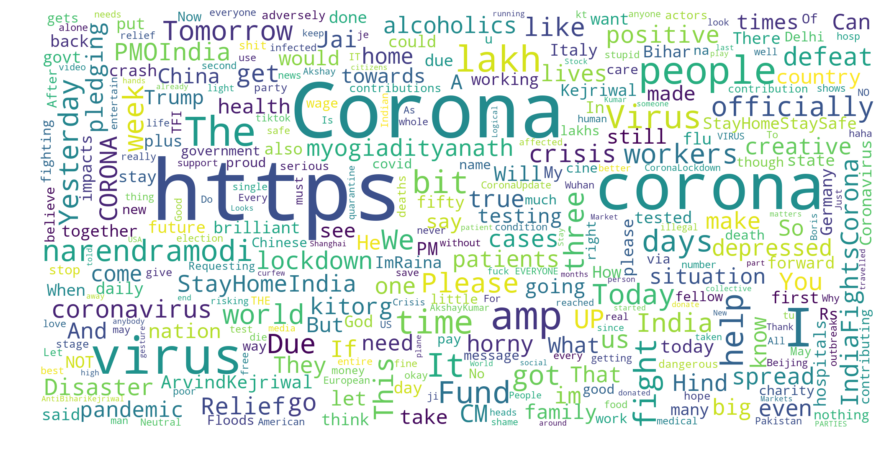

In [213]:
# vocabulary word cloud 1-gram
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate_from_frequencies(words_total_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [214]:
words_total_dict.most_common(30)

[('https', 357657),
 ('Corona', 297621),
 ('corona', 202947),
 ('I', 137128),
 ('virus', 119552),
 ('The', 72653),
 ('amp', 71659),
 ('people', 65287),
 ('lakh', 56319),
 ('It', 46603),
 ('time', 46556),
 ('Virus', 43809),
 ('bit', 41911),
 ('help', 41029),
 ('Fund', 39555),
 ('fight', 38474),
 ('days', 37828),
 ('narendramodi', 36258),
 ('week', 33379),
 ('Today', 33150),
 ('We', 31895),
 ('Please', 30685),
 ('got', 30532),
 ('three', 30350),
 ('officially', 30274),
 ('Yesterday', 30242),
 ('Due', 30219),
 ('workers', 30017),
 ('Tomorrow', 29716),
 ('world', 29317)]

# 2-Gram Word Cloud

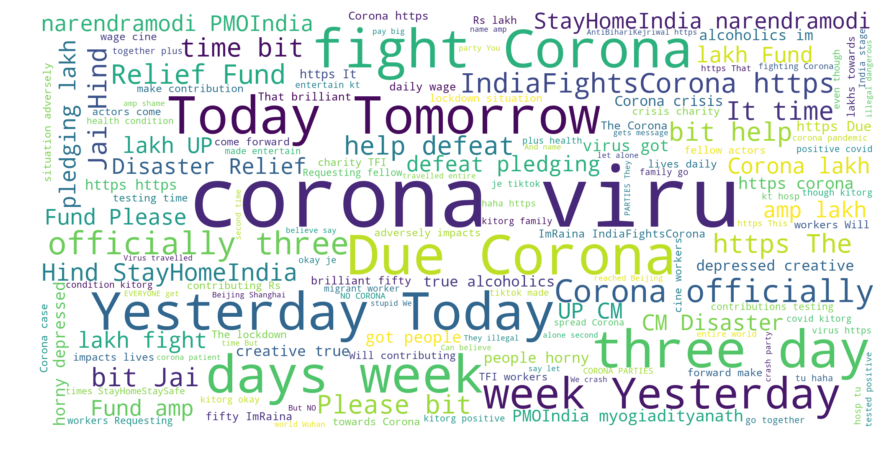

In [215]:
# vocabulary word cloud 2-gram 
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate(' '.join(all_words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [216]:
wordcloud.words_

{'corona viru': 1.0,
 'Due Corona': 0.3143943704715299,
 'fight Corona': 0.2885797200409696,
 'three day': 0.28032889495846136,
 'days week': 0.28027199271651304,
 'Yesterday Today': 0.2802245741815561,
 'Today Tomorrow': 0.28009180228367664,
 'week Yesterday': 0.2800538674557111,
 'Corona officially': 0.27990212814384885,
 'officially three': 0.27981677478092637,
 'IndiaFightsCorona https': 0.2047342665301013,
 'Relief Fund': 0.19876901483251774,
 'https The': 0.187872235499412,
 'Jai Hind': 0.18246652251432038,
 'It time': 0.18183111414589734,
 'Please bit': 0.1806835855999393,
 'bit Jai': 0.18064565077197375,
 'help defeat': 0.1804370092181632,
 'time bit': 0.18030423732028375,
 'bit help': 0.18030423732028375,
 'Hind StayHomeIndia': 0.18029475361329236,
 'StayHomeIndia narendramodi': 0.18029475361329236,
 'narendramodi PMOIndia': 0.1770513258222374,
 'amp lakh': 0.17639695003983158,
 'Fund amp': 0.17549599787564962,
 'Corona lakh': 0.17522097037289935,
 'lakh fight': 0.175164068130

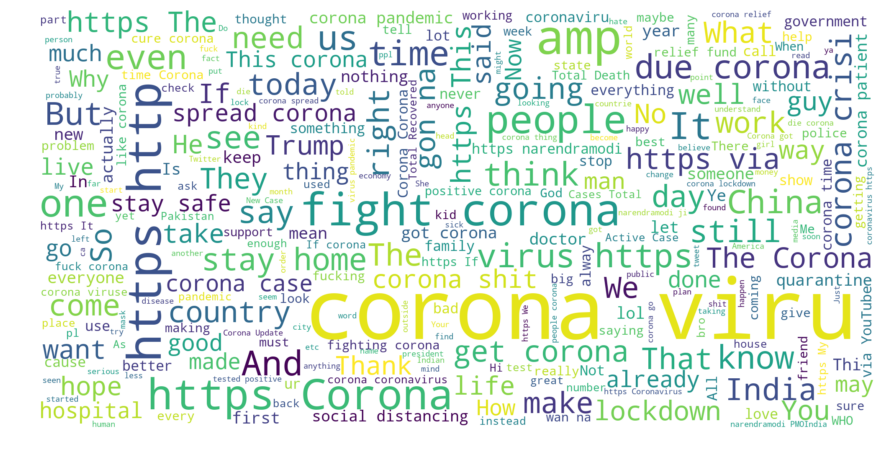

In [217]:
# vocabulary word cloud 2-gram 
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate(' '.join(all_words_orig))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [218]:
wordcloud.words_

{'corona viru': 1.0,
 'amp': 0.149451844866203,
 'https http': 0.13822939997642344,
 'fight corona': 0.12575739714723566,
 'https Corona': 0.11413415065424967,
 'people': 0.09939879759519038,
 'one': 0.09484852057055287,
 'It': 0.08786985736178239,
 'time': 0.07386537781445243,
 'even': 0.07296946834846163,
 'us': 0.07240363079099375,
 'And': 0.07193209949310385,
 'virus https': 0.0671224802546269,
 'due corona': 0.06676883178120947,
 'know': 0.06360957208534716,
 'think': 0.0634209595661912,
 'China': 0.0634209595661912,
 'But': 0.0625250501002004,
 'say': 0.061416951550159145,
 'see': 0.061322645290581165,
 'The': 0.05993162796180596,
 'still': 0.05957797948838854,
 'stay home': 0.059554402923494044,
 'India': 0.05759754803725097,
 'day': 0.056583755746787694,
 'today': 0.05448544147117765,
 'come': 0.054414711776494165,
 'going': 0.05427325238712719,
 'right': 0.053896027348815274,
 'need': 0.05328303666155841,
 'That': 0.05309442414240245,
 'corona crisi': 0.05300011788282447,
 'co

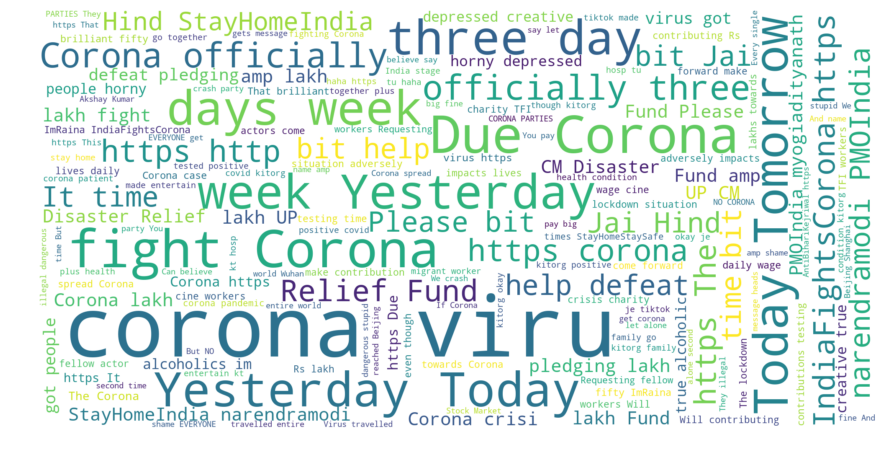

In [219]:
# vocabulary word cloud 2-gram 
wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=2000, background_color="white").generate(' '.join(all_words_total))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [220]:
wordcloud.words_

{'corona viru': 1.0,
 'Due Corona': 0.24336022832563456,
 'fight Corona': 0.24187232430897004,
 'three day': 0.20055593504622649,
 'days week': 0.20052211904584774,
 'Yesterday Today': 0.2003462758438783,
 'Today Tomorrow': 0.2002515910428178,
 'week Yesterday': 0.20010280064115138,
 'Corona officially': 0.2000351686403939,
 'officially three': 0.19981198303789421,
 'https corona': 0.15462028013174714,
 'https http': 0.15184060490061477,
 'IndiaFightsCorona https': 0.14888508646751297,
 'Relief Fund': 0.14812084485895347,
 'https The': 0.1475324464523634,
 'Jai Hind': 0.1325587214846577,
 'narendramodi PMOIndia': 0.13157805747367424,
 'It time': 0.13109787026829614,
 'Please bit': 0.12925827984769273,
 'help defeat': 0.12917712144678375,
 'bit Jai': 0.129170358246708,
 'bit help': 0.12911625264610202,
 'time bit': 0.1290418574452688,
 'Hind StayHomeIndia': 0.12889306704360234,
 'StayHomeIndia narendramodi': 0.12887954064345086,
 'Corona crisi': 0.12719550382458963,
 'amp lakh': 0.12597

# Topic Modelling
using unique tweets in df table

In [221]:
from nltk.corpus import wordnet
# nltk.download('wordnet')
def prepare_text_for_lda(word):
    if word not in stopwordEn and word.isalpha():
        lemma = wordnet.morphy(word)
        if lemma is not None:
            return lemma
        else:
            return word

In [222]:
text_data = []
for t in tqdm(df['text']):
    tokens = []
    for w in word_tokenize(t):
        token = prepare_text_for_lda(w)
        if token is not None:
            tokens.append(token)
    text_data.append(tokens)

100%|██████████| 46892/46892 [00:51<00:00, 907.25it/s] 


In [223]:
text_data_orig = []
for t in tqdm(df_orig['text']):
    tokens = []
    for w in word_tokenize(t):
        token = prepare_text_for_lda(w)
        if token is not None:
            tokens.append(token)
    text_data_orig.append(tokens)

100%|██████████| 191354/191354 [03:07<00:00, 1020.95it/s]


In [226]:
def prepare_lda(t):
    tokens = []
    for word in word_tokenize(t):
        if word not in stopwordEn and word.isalpha():
            lemma = wordnet.morphy(word)
            if lemma is not None:
                tokens.append(lemma)
            else:
                tokens.append(word)
    return tokens
s_py = time.time()
text_data_orig1 = apply_by_multiprocessing(df_orig['text'], prepare_lda, workers=32)
print("programme:",time.time()-s_py)

programme: 13.478476285934448


In [238]:
s_py = time.time()
text_data_total = apply_by_multiprocessing(df_total['text'], prepare_lda, workers=32)
print("programme:",time.time()-s_py)

programme: 20.96286106109619


In [231]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = apply_by_multiprocessing(pd.Series(text_data), dictionary.doc2bow, workers=32)
# corpus = [dictionary.doc2bow(text) for text in text_data]

In [232]:
import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.033*"http" + 0.020*"corona" + 0.013*"Corona"')
(1, '0.035*"CoronaLockdown" + 0.027*"CoronavirusOutbreak" + 0.023*"CoronaUpdate"')
(2, '0.122*"http" + 0.093*"Corona" + 0.039*"Virus"')
(3, '0.040*"na" + 0.024*"gon" + 0.015*"human"')
(4, '0.067*"http" + 0.039*"Corona" + 0.026*"corona"')
(5, '0.034*"cure" + 0.031*"disease" + 0.023*"true"')
(6, '0.031*"hands" + 0.028*"Is" + 0.018*"water"')
(7, '0.060*"CORONA" + 0.034*"http" + 0.026*"THE"')
(8, '0.042*"Stay" + 0.024*"someone" + 0.015*"Home"')
(9, '0.035*"case" + 0.020*"Corona" + 0.012*"state"')
(10, '0.029*"http" + 0.021*"Ji" + 0.019*"Rampal"')
(11, '0.054*"corona" + 0.049*"http" + 0.042*"I"')


In [233]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [239]:
# total
from gensim import corpora
dictionary = corpora.Dictionary(text_data_total)
corpus = apply_by_multiprocessing(pd.Series(text_data_total), dictionary.doc2bow, workers=32)
# corpus = [dictionary.doc2bow(text) for text in text_data]

import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

(0, '0.093*"I" + 0.076*"corona" + 0.033*"http"')
(1, '0.053*"http" + 0.036*"Corona" + 0.029*"fight"')
(2, '0.040*"corona" + 0.038*"people" + 0.019*"virus"')
(3, '0.200*"http" + 0.112*"Corona" + 0.038*"Virus"')
(4, '0.078*"http" + 0.042*"Corona" + 0.034*"home"')
(5, '0.046*"na" + 0.026*"gon" + 0.024*"fuck"')
(6, '0.044*"Corona" + 0.042*"http" + 0.039*"virus"')
(7, '0.022*"corona" + 0.012*"lot" + 0.012*"Italy"')
(8, '0.066*"case" + 0.046*"death" + 0.028*"Total"')
(9, '0.055*"CORONA" + 0.043*"http" + 0.020*"THE"')
(10, '0.040*"corona" + 0.033*"test" + 0.022*"patient"')
(11, '0.019*"Delhi" + 0.016*"control" + 0.014*"ArvindKejriwal"')


In [240]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# Get Overlap words

In [35]:
with open('032829_tweets_wordcloud_words.pickle','rb') as handle:
    dict_news = pickle.load(handle)

In [42]:
with open('032829_wordcloud_words_2gram.pickle','rb') as handle:
    dict_news_2g = pickle.load(handle)

In [55]:
dict_tweets2g = wordcloud.words_

In [73]:
dict_news_2g

{'New York': 1.0,
 'coronavirus pandemic': 0.5581711390072556,
 'social distancing': 0.5246573764827824,
 'public health': 0.4562248070943222,
 'tested positive': 0.43593228146953816,
 'confirmed case': 0.38555798687089715,
 'Prime Minister': 0.3676148796498906,
 'stay home': 0.36012898767707013,
 'coronavirus outbreak': 0.35994471956696994,
 'United State': 0.3381550155476218,
 'health care': 0.33472302199700565,
 'last week': 0.25995623632385123,
 'coronavirus case': 0.2509270989289416,
 'Donald Trump': 0.24869284809397674,
 'well': 0.24212829667165725,
 'two week': 0.24044685016699296,
 'new coronavirus': 0.23904180582747897,
 'novel coronaviru': 0.2286997581481055,
 'social media': 0.22342508349648738,
 'spread coronaviru': 0.2222964413221237,
 'York City': 0.20896003685362202,
 'President Donald': 0.20525164113785557,
 'federal government': 0.19940112864217435,
 'Associated Press': 0.19596913509155822,
 'new case': 0.19041805827478983,
 'per cent': 0.18666359553149833,
 'New Jerse

In [71]:
dict_tweets2g

{'corona virus': 1.0,
 'Relief Fund': 0.20864873570623288,
 'Fund corona': 0.1536479304235787,
 'PM CARE': 0.1536479304235787,
 'Any idea': 0.15211789338057657,
 'PM Relief': 0.15203736511515542,
 'corona already': 0.15187630858431309,
 'Why need': 0.15187630858431309,
 'CARES Fund': 0.15179578031889193,
 'need separate': 0.1516347237880496,
 'Fund Any': 0.15131261072636495,
 'separate PM': 0.1512320824609438,
 'already PM': 0.1512320824609438,
 'idea guys': 0.1512320824609438,
 'first thing': 0.1277983572233854,
 'What first': 0.11885971976163634,
 'IMAGINE CORONA': 0.1067804799484619,
 'VIRUS START': 0.10653889515219842,
 'Did You': 0.10597519729425028,
 'STARTS KILLING': 0.10589466902882912,
 'KILLING ALPHABETICALLY': 0.10589466902882912,
 'You Call': 0.10581414076340796,
 'Call That': 0.1057336124979868,
 'That Your': 0.1057336124979868,
 'ALPHABETICALLY Did': 0.10565308423256563,
 'Your Name': 0.10565308423256563,
 'Name Again': 0.10565308423256563,
 'virus RT': 0.0914801095184409

In [58]:
dict_tweets = wordcloud.words_

In [43]:
len(dict_tweets),len(dict_news_2g)

(2000, 2000)

In [37]:
co_words = [i for i in dict_tweets.keys() for v in dict_news.keys() if i==v]
len(co_words)

977

In [69]:
co_words_2g = [i for i in dict_tweets2g.keys() for v in dict_news_2g.keys() if i==v]
len(co_words_2g)

79

In [87]:
df_cowords_2g = pd.DataFrame({'co_words':co_words_2g})
df_cowords_2g['tweets'] = [dict_tweets2g[i] for i in co_words_2g]
df_cowords_2g['news'] = [dict_news_2g[i] for i in co_words_2g]
df_cowords_2g

co_words    tweets      news
0      Relief Fund  0.208649  0.041483
1   Prime Minister  0.058544  0.367615
2       daily wage  0.056209  0.018358
3         hot spot  0.038090  0.055050
4           gon na  0.037043  0.027778
..             ...       ...       ...
74           light  0.002818  0.016584
75       come back  0.002818  0.036209
76    people still  0.002818  0.029736
77       wash hand  0.002818  0.064885
78          change  0.002657  0.074859

[79 rows x 3 columns]

In [88]:
df_cowords = pd.DataFrame({'co_words':co_words})
df_cowords['tweets'] = [dict_tweets[i] for i in co_words]
df_cowords['news'] = [dict_news[i] for i in co_words]
df_cowords

co_words    tweets      news
0     corona  1.000000  0.009117
1     Corona  0.877477  0.008586
2      virus  0.487130  0.241588
3          I  0.390347  0.539432
4         PM  0.312227  0.029791
..       ...       ...       ...
972    looks  0.001931  0.009562
973    stage  0.001931  0.009530
974   supply  0.001931  0.032812
975      CDC  0.001931  0.020499
976   member  0.001931  0.024612

[977 rows x 3 columns]

In [90]:
with open('032829_df_cowords.pickle','wb') as handle:
    pickle.dump(df_cowords, handle)
with open('032829_df_cowords_2g.pickle','wb') as handle:
    pickle.dump(df_cowords_2g, handle)